In [9]:
import torch
from torch import nn
import numpy
import matplotlib.pyplot as plt

In [ ]:
"""
PyTorch workflow

1. get data ready
2. build or pick a pre-trained model - (pick a loss function and optimizer)
3. Fit the model to the data and make prediction 
4. evaluate the model
5. improve through experimentation
6. save and reload the trained model
"""

In [3]:
# here we will try to create a model that learns to fit a straight line
weight = 0.7
bias = 0.3

#Create data
start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight*X + bias

X.shape


torch.Size([50, 1])

In [4]:
## Spliting data into train and test set

In [6]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [22]:
### Creating a function to visualize the data

def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
    """
    Plot training data, test data and compare the predictions
    """

    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot the test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Test data")

    if predictions is not None:
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})

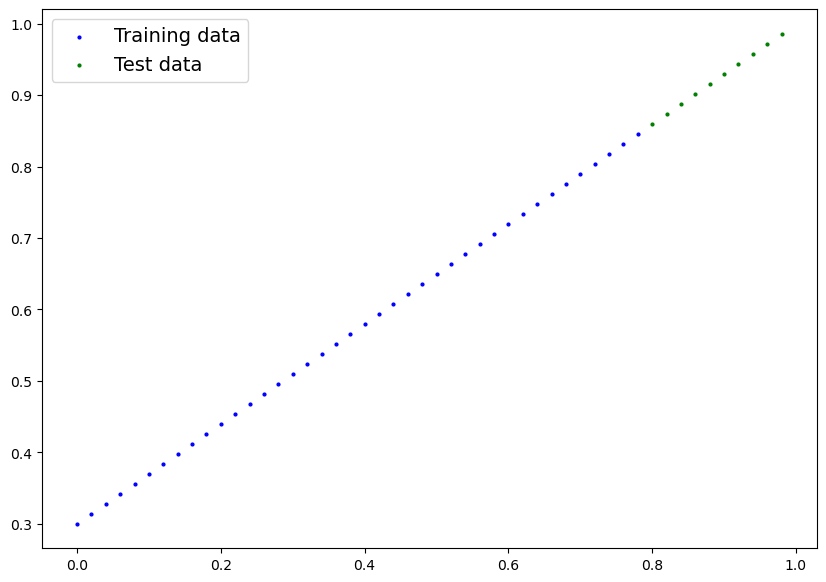

In [23]:
plot_predictions()

In [13]:
### Build the model
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, dtype=torch.float32, requires_grad=True)) # require_grad - as we want this value to be updated during training
        self.bias = nn.Parameter(torch.randn(1, dtype=torch.float32, requires_grad=True))

    def forward(self, x: torch.Tensor) -> torch.Tensor :
        return self.weights *  x + self.bias

In [14]:
##  Checking the contents of the pytorch model
torch.manual_seed(42)

# Creating an instance of the model
model_0 = LinearRegressionModel()

## Checking the nn.Parameters() within the nn.Module subclass that were created
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [15]:
## Getting the state of the model parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [16]:
#### making prediction using torch.inference_mode()

"""
Note: when using inference_mode as a context manager, it turns off a bunch of things

"""
with torch.inference_mode():
    y_preds = model_0(X_test)

In [19]:
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [17]:
### Note: we didn't actually train the model yet, but did a single forward pass, and can visualize how the lines look like

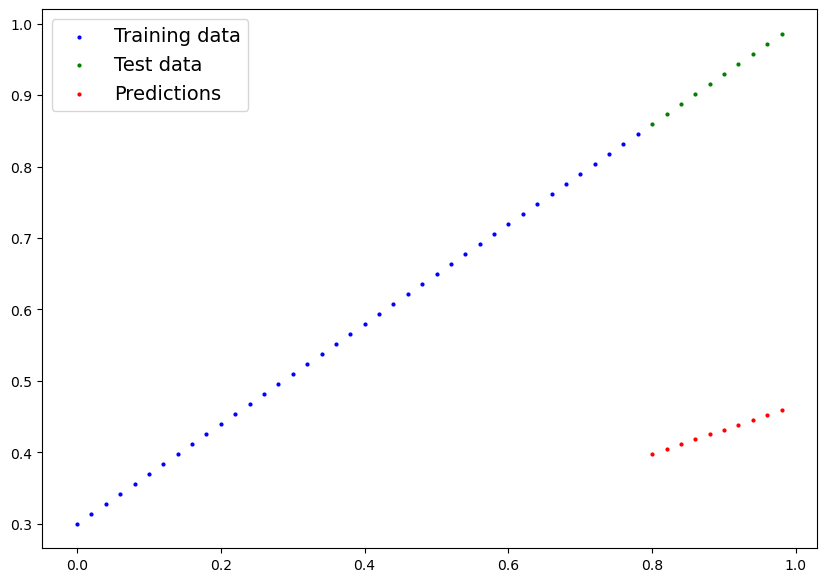

In [24]:
plot_predictions(predictions=y_preds)

In [25]:
# Technically we want the above red dots to be as closely aligned to the green dots just to make sure that the model has learned.

In [26]:
# Creating a loss function and optimizer
# Loss function - measure how wrong the model predictions are - eg: MAE for regression (L1lsss), Binary Cross-Entropy for Binary Classification
# Optimizer - tells the model how to update the interal params to best lower the loss - eg: torch.optim.SGD, Adam

In [27]:
# Create the loss function
loss_fn = nn.L1Loss() #MAE Loss is same as L1loss

# Create the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)

In [28]:
### Creating a optimization loop in pytorch

In [29]:
"""
Pytorch training loop

1. Forward pass - > model(train_data)
2. Calculate the loss -> loss = loss_fn(y_pred, y_train)
3. Zero gradients -> the optimizers gradients are set to zero, so that they can be    -> optimizer.zero_grad()
                     recalculated for a specific training step
4. Perform backprop on the loss -> computes the gradient of the loss wrt each model param to be updated -> loss.backward()
                                (i.e the ones with require_grad=Tuue)

5. Update the optimizer -> update the paramaters with respect to the loss gradients to improve them -> optimizer.step()                                
"""

'\nPytorch training loop\n\n1. Forward pass - > model(train_data)\n2. Calculate the loss -> loss = loss_fn(y_pred, y_train)\n3. Zero gradients -> the optimizers gradients are set to zero, so that they can be    -> optimizer.zero_grad()\n                     recalculated for a specific training step\n4. Perform backprop on the loss -> computes the gradient of the loss wrt each model param to be updated -> loss.backward()\n                                (i.e the ones with require_grad=Tuue)\n\n5. Update the optimizer -> update the paramaters with respect to the loss gradients to improve them -> optimizer.step()                                \n'